In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from pandas import Series
import os
import seaborn as sns
%matplotlib inline
import warnings
import math
from fancyimpute import KNN

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.regressionplots import *
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

from sklearn.impute import SimpleImputer
import statsmodels.api as sm
import statsmodels.formula.api as sf
from statsmodels.tsa.stattools import acf, pacf 



from UtilityFunctions import *
from ReduceVIF import ReduceVIF
sns.set(rc={'figure.figsize':(7,5)})

In [48]:
os.chdir("G://ml//edwiser//employee absentesm")

In [49]:
Data = pd.read_excel("Absenteeism_at_work_Project.xls",na_values=None)

In [50]:
def change_category():
    #Data.loc[:,'ID'] = pd.Categorical(Data.loc[:,'ID'])
    Data.loc[:,'Reason for absence'] = pd.Categorical(Data.loc[:,'Reason for absence'])
    Data.loc[:,'Month of absence'] = pd.Categorical(Data.loc[:,'Month of absence'])
    Data.loc[:,'Year'] = pd.Categorical(Data.loc[:,'Year'])
    Data.loc[:,'Day of the week'] = pd.Categorical(Data.loc[:,'Day of the week'])
    Data.loc[:,'Seasons'] = pd.Categorical(Data.loc[:,'Seasons'])
    Data.loc[:,'Disciplinary failure'] = pd.Categorical(Data.loc[:,'Disciplinary failure'])
    Data.loc[:,'Social drinker'] = pd.Categorical(Data.loc[:,'Social drinker'])
    Data.loc[:,'Education'] = pd.Categorical(Data.loc[:,'Education'])
    Data.loc[:,'Social smoker'] = pd.Categorical(Data.loc[:,'Social smoker'])
    Data.loc[:,'Education'] = pd.Categorical(Data.loc[:,'Education'])
    Data.loc[:,'Son'] = pd.Categorical(Data.loc[:,'Son'])
    Data.loc[:,'Pet'] = pd.Categorical(Data.loc[:,'Pet'])


In [51]:
def createDummies(Data):
    dummy_data = Data.copy()
    category_columns = get_column_bytype(Data, 'category')
    print('Dummy columns created for: ',category_columns)
    dummy_data = dummy_data.drop(category_columns, axis = 1)
    for column in category_columns:
        dummies = pd.get_dummies(Data[column])
        dum_col_list = []
        for dum_col in Data[column].cat.categories:
            dum_col_list.append("".join([column, str(dum_col)]))
        dummies.columns = dum_col_list
        dummy_data= dummy_data.merge(dummies,left_index = True, right_index = True)
    return dummy_data

In [52]:
Missing_value = pd.DataFrame(Data.isnull().sum())

In [53]:
Missing_value

,0
ID,0
Reason for absence,3
Month of absence,1
Day of the week,0
Seasons,0
Transportation expense,7
Distance from Residence to Work,3
Service time,3
Age,3
Work load Average/day,10


## Pre-processing work

In [54]:
Data.loc[66,'Month of absence'] = 10

In [55]:
#Adding year column
Data['Year'] = 0

Data.iloc[0:113,21] = 2007
Data.iloc[113:358,21] = 2008
Data.iloc[358:570,21] = 2009
Data.iloc[570:737,21] = 2010

Data = Data.iloc[0:737,:]

In [56]:
col = ['ID', 'Reason for absence', 'Month of absence', 'Day of the week', 'Year',
       'Seasons', 'Transportation expense', 'Distance from Residence to Work',
       'Service time', 'Age', 'Work load Average/day ', 'Hit target',
       'Disciplinary failure', 'Education', 'Son', 'Social drinker',
       'Social smoker', 'Pet', 'Weight', 'Height', 'Body mass index',
       'Absenteeism time in hours']

Data = Data[col]
Data.head(2)

,ID,Reason for absence,Month of absence,Day of the week,Year,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,...,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
0,11,26.0,7.0,3,2007,1,289.0,36.0,13.0,33.0,...,0.0,1.0,2.0,1.0,0.0,1.0,90.0,172.0,30.0,4.0
1,36,0.0,7.0,3,2007,1,118.0,13.0,18.0,50.0,...,1.0,1.0,1.0,1.0,0.0,0.0,98.0,178.0,31.0,0.0


In [57]:
change_category()

## Missing value

In [58]:
def impute(Data):
    Data = imputeCategoricalVariables(Data)
    imputer = SimpleImputer(strategy='median')
    Data = pd.DataFrame(imputer.fit_transform(Data), columns=Data.columns)
    return Data

In [59]:
Data = impute(Data)

Reason for absence 23.0
Month of absence 3.0
Day of the week 2
Year 2008
Seasons 4
Disciplinary failure 0.0
Education 1.0
Son 0.0
Social drinker 1.0
Social smoker 0.0
Pet 0.0


In [37]:
Data.dtypes

ID                                 float64
Reason for absence                 float64
Month of absence                   float64
Day of the week                    float64
Year                               float64
Seasons                            float64
Transportation expense             float64
Distance from Residence to Work    float64
Service time                       float64
Age                                float64
Work load Average/day              float64
Hit target                         float64
Disciplinary failure               float64
Education                          float64
Son                                float64
Social drinker                     float64
Social smoker                      float64
Pet                                float64
Weight                             float64
Height                             float64
Body mass index                    float64
Absenteeism time in hours          float64
Productivity                       float64
dtype: obje

In [60]:
change_category()
Data_dum = createDummies(Data)
Data_dum.shape

Dummy columns created for:  ['Reason for absence', 'Month of absence', 'Day of the week', 'Year', 'Seasons', 'Disciplinary failure', 'Education', 'Son', 'Social drinker', 'Social smoker', 'Pet']


(737, 85)

## Fact analysis

G:\Anaconda\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


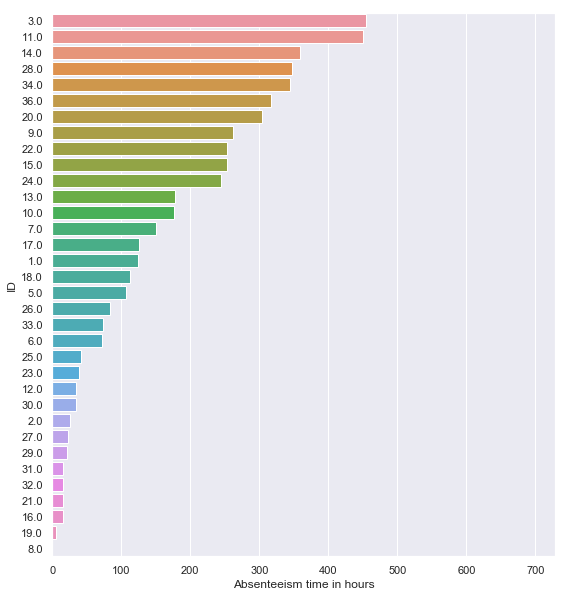

In [18]:
sns.set(rc={'figure.figsize':(9,10)})

order = get_sum_order(Data, 'ID', 'Absenteeism time in hours', False)
sns.barplot(y='ID', x = "Absenteeism time in hours", data = Data, estimator=sum, order = order, errwidth=0)

G:\Anaconda\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


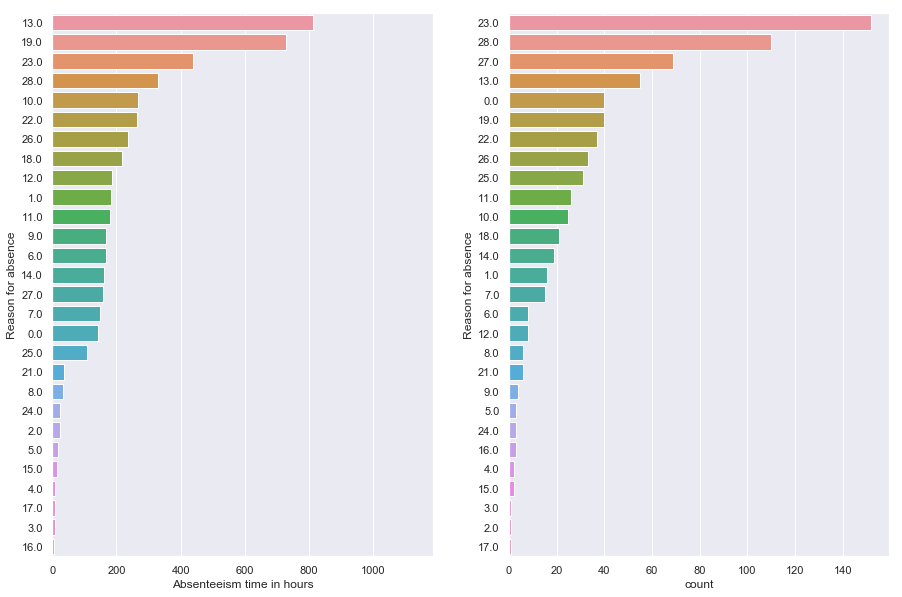

In [19]:
sns.set(rc={'figure.figsize':(15,10)})
fig, ax = plt.subplots(1, 2)

order = get_sum_order(Data, 'Reason for absence', 'Absenteeism time in hours', False)
sns.barplot(y='Reason for absence', x = "Absenteeism time in hours", data = Data, estimator=sum, order = order, errwidth=0, ax = ax[0])
sns.countplot(y='Reason for absence', data = Data, order = Data['Reason for absence'].value_counts().index, ax=ax[1])

G:\Anaconda\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


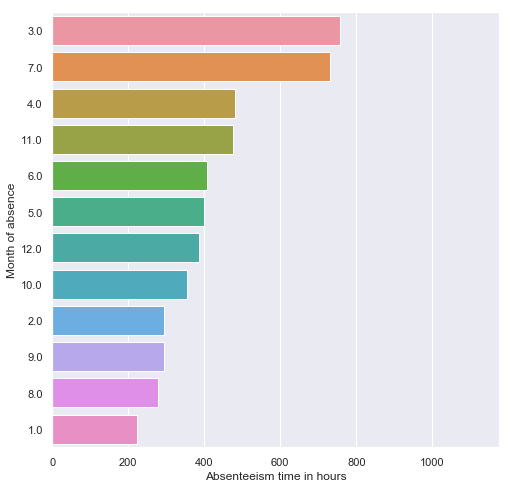

In [20]:
sns.set(rc={'figure.figsize':(8,8)})
order = get_sum_order(Data, 'Month of absence', 'Absenteeism time in hours', False)
sns.barplot(y="Month of absence", x = "Absenteeism time in hours",estimator = sum, data = Data, order = order, errwidth=0)

G:\Anaconda\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


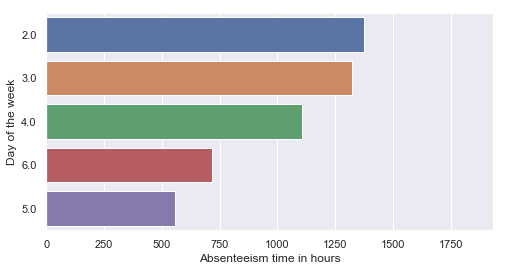

In [21]:
sns.set(rc={'figure.figsize':(8,4)})
order = get_sum_order(Data, 'Day of the week', 'Absenteeism time in hours', False)
sns.barplot(y="Day of the week", x = "Absenteeism time in hours",estimator = sum, data = Data, order = order, errwidth=0)

G:\Anaconda\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


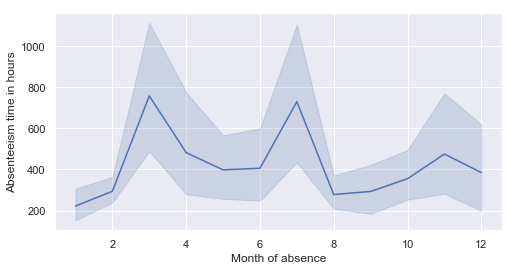

In [22]:
sns.lineplot(x = 'Month of absence', y = 'Absenteeism time in hours', data = Data,estimator=sum)
warnings.filterwarnings(action='once')

G:\Anaconda\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


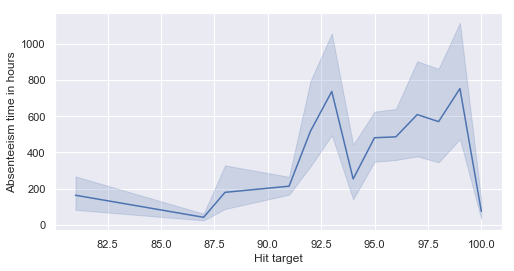

In [23]:
sns.lineplot(x = 'Hit target', y = 'Absenteeism time in hours', data = Data,estimator=sum)

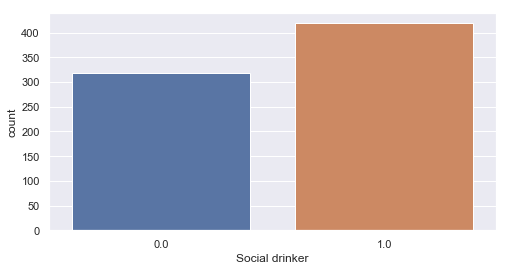

In [24]:
sns.countplot(Data['Social drinker'])

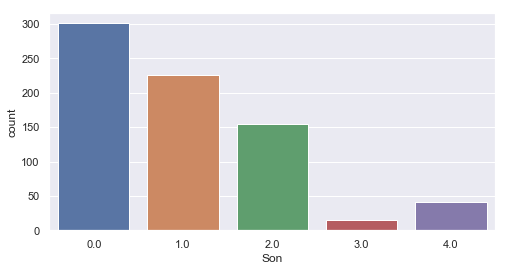

In [25]:
sns.countplot(Data['Son'])

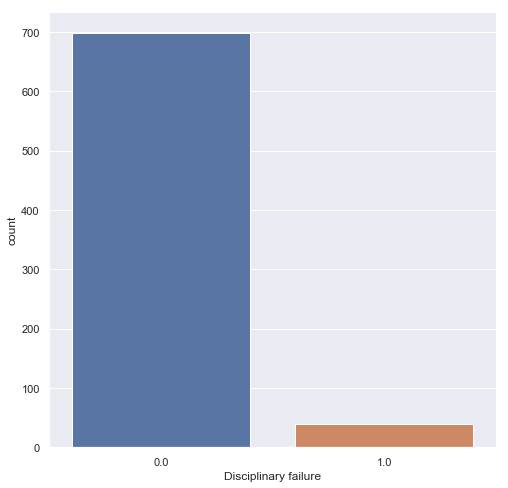

In [26]:
sns.set(rc={'figure.figsize':(8,8)})
sns.countplot(Data['Disciplinary failure'])

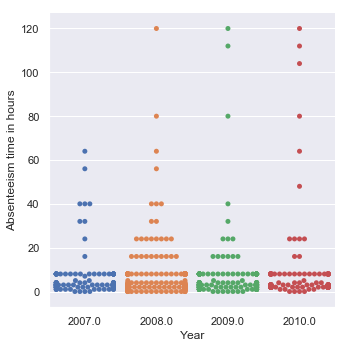

In [27]:
sns.set(rc={'figure.figsize':(10,8)})
sns.catplot(x = 'Year', y = 'Absenteeism time in hours',kind='swarm', data = Data)

G:\Anaconda\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


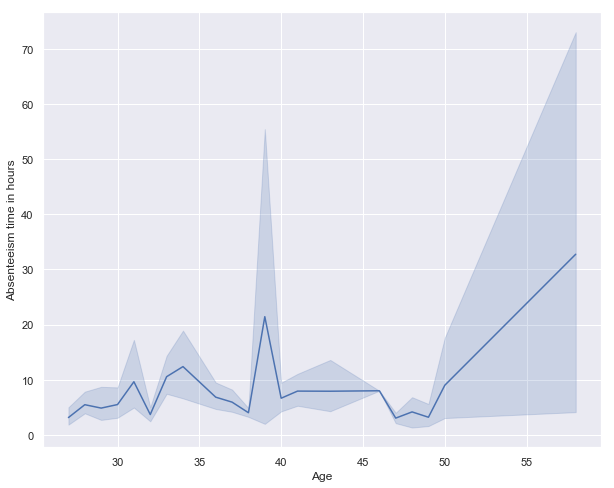

In [28]:
sns.lineplot(x = 'Age', y = 'Absenteeism time in hours', data = Data)

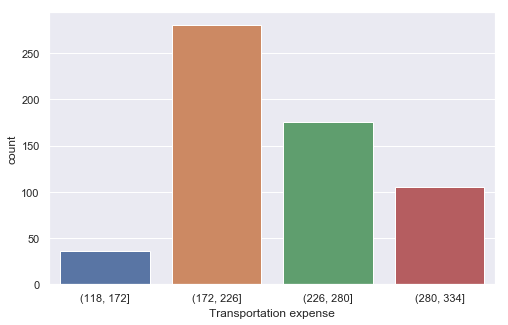

In [29]:
sns.set(rc={'figure.figsize':(8,5)})
bins = bin(Data['Transportation expense'].min(),Data['Transportation expense'].max(),5)
sns.countplot(pd.cut(Data['Transportation expense'],bins=bins))

G:\Anaconda\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


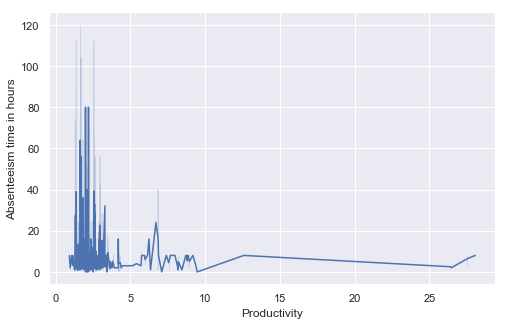

In [30]:
Data['Productivity'] = (Data['Work load Average/day '])/(Data['Service time']*10000)
sns.lineplot(x = 'Productivity', y = 'Absenteeism time in hours', data = Data)

In [31]:
warnings.filterwarnings(action='once')
os.chdir("G://ml//edwiser//employee absentesm//bar")
sns.set(rc={'figure.figsize':(10,5)})
for i in Data.columns:
    #snsplot = sns.countplot(Data[i])
    snsplot = sns.barplot(x=i, y = "Absenteeism time in hours", data = Data, estimator=sum)
    if (i == 'Work load Average/day '):
        i = 'Work load Average per day'
    plt.savefig(i+'.png')
    plt.clf()


G:\Anaconda\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
G:\Anaconda\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
G:\Anaconda\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future

<Figure size 720x360 with 0 Axes>

# Model Generation

## Outlier Analysis

In [61]:
change_category()
Data.dtypes

ID                                  float64
Reason for absence                 category
Month of absence                   category
Day of the week                    category
Year                               category
Seasons                            category
Transportation expense              float64
Distance from Residence to Work     float64
Service time                        float64
Age                                 float64
Work load Average/day               float64
Hit target                          float64
Disciplinary failure               category
Education                          category
Son                                category
Social drinker                     category
Social smoker                      category
Pet                                category
Weight                              float64
Height                              float64
Body mass index                     float64
Absenteeism time in hours           float64
dtype: object

In [64]:
numeric_col

['Transportation expense',
 'Distance from Residence to Work',
 'Service time',
 'Age',
 'Work load Average/day ',
 'Hit target',
 'Weight',
 'Height',
 'Body mass index']

In [65]:
numeric_col = get_column_bytype(Data, 'float64')
numeric_col.remove('Absenteeism time in hours')
numeric_col.remove('ID')

num_col_array = np.array(numeric_col)
num_col_array.shape=(3,3)
print(num_col_array)

[['Transportation expense' 'Distance from Residence to Work'
  'Service time']
 ['Age' 'Work load Average/day ' 'Hit target']
 ['Weight' 'Height' 'Body mass index']]


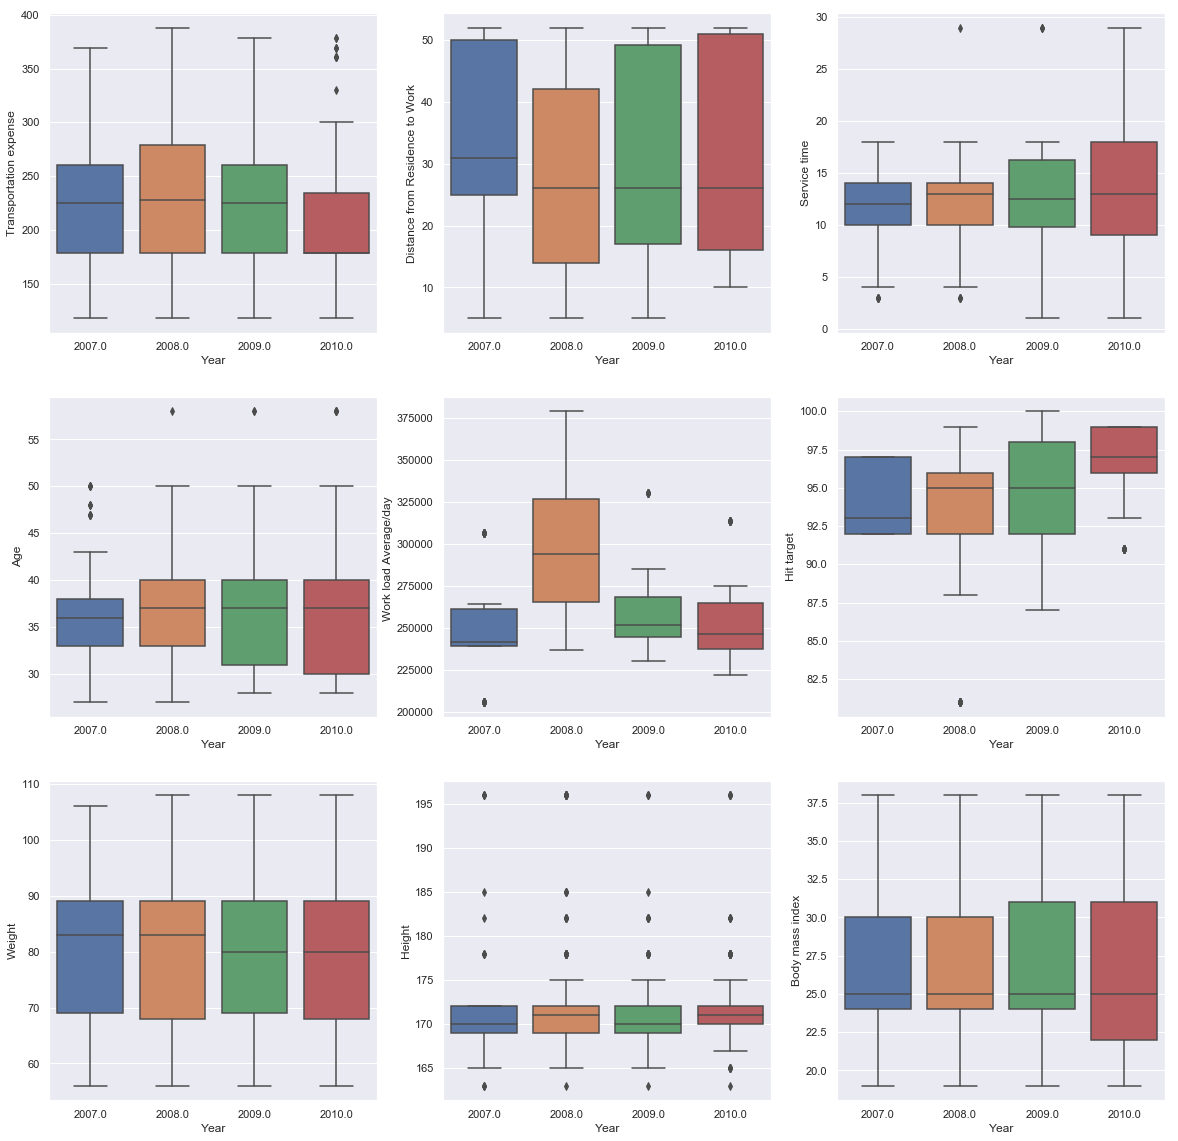

In [66]:
sns.set(rc={'figure.figsize':(20,20)})
fig, ax = plt.subplots(3,3)
for row in range(3):
    for col in range(3):
        sns.boxplot(x = 'Year', y = num_col_array[row][col], data = Data, ax=ax[row][col])


In [67]:
for i in numeric_col:
    q75, q25 = np.percentile(Data[i]  , [75,25])
    iqr = q75-q25
    
    min = q25-iqr*1.5
    max = q75+iqr*1.5
    
        #Median as replacement value
    replacementValue=np.median(Data[i])
        #Mean as replacement value
        #replacementValue=np.mean(Data[i])
    
    Data.loc[Data[i]<=min,i]=replacementValue
    Data.loc[Data[i]>max,i]=replacementValue

In [68]:
ydat = np.asarray(Data['Absenteeism time in hours'], dtype='float')#pd.DataFrame(Data['Absenteeism time in hours'], columns=['Absenteeism time in hours'])
col = ['ID', 'Reason for absence', 'Month of absence', 'Day of the week', 'Year',
       'Seasons', 'Transportation expense', 'Distance from Residence to Work',
       'Service time', 'Age', 'Work load Average/day ', 'Hit target',
       'Disciplinary failure', 'Education', 'Son', 'Social drinker',
       'Social smoker', 'Pet', 'Weight', 'Height', 'Body mass index']

xdat = np.asarray(Data[col], dtype='float') 
model = sf.OLS(endog = ydat, exog= xdat, hasconst=False, data = xdat).fit()

In [69]:
model.resid
model_leverage = model.get_influence().hat_matrix_diag
model_cooks = model.get_influence().cooks_distance[0]

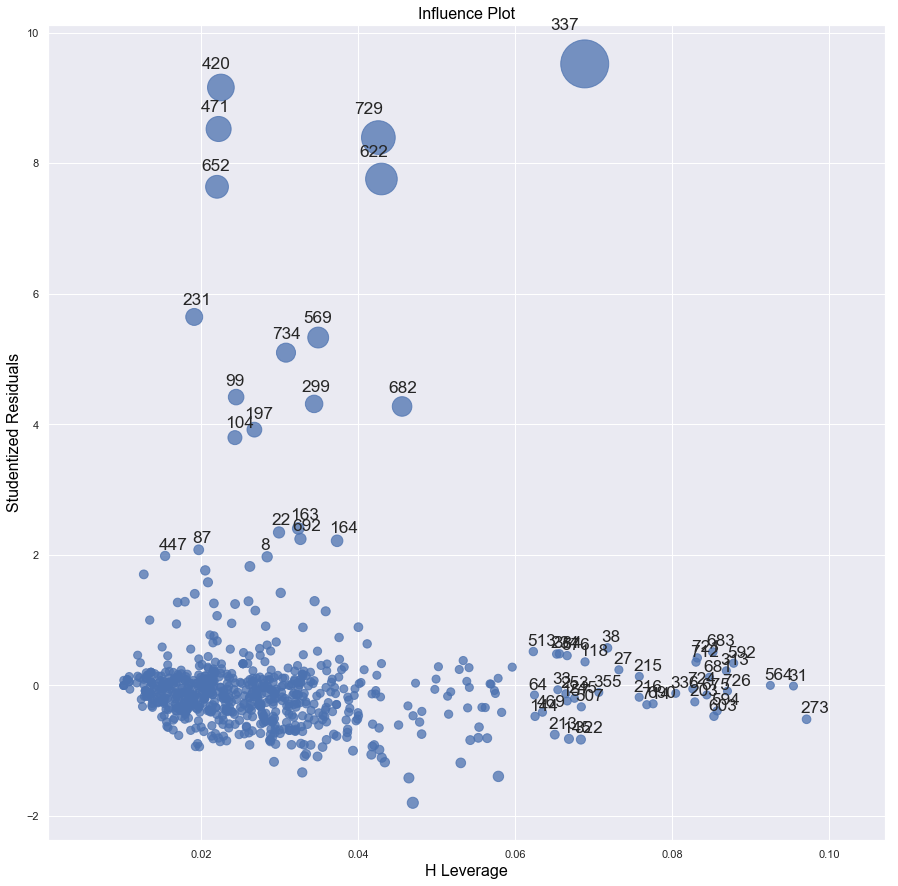

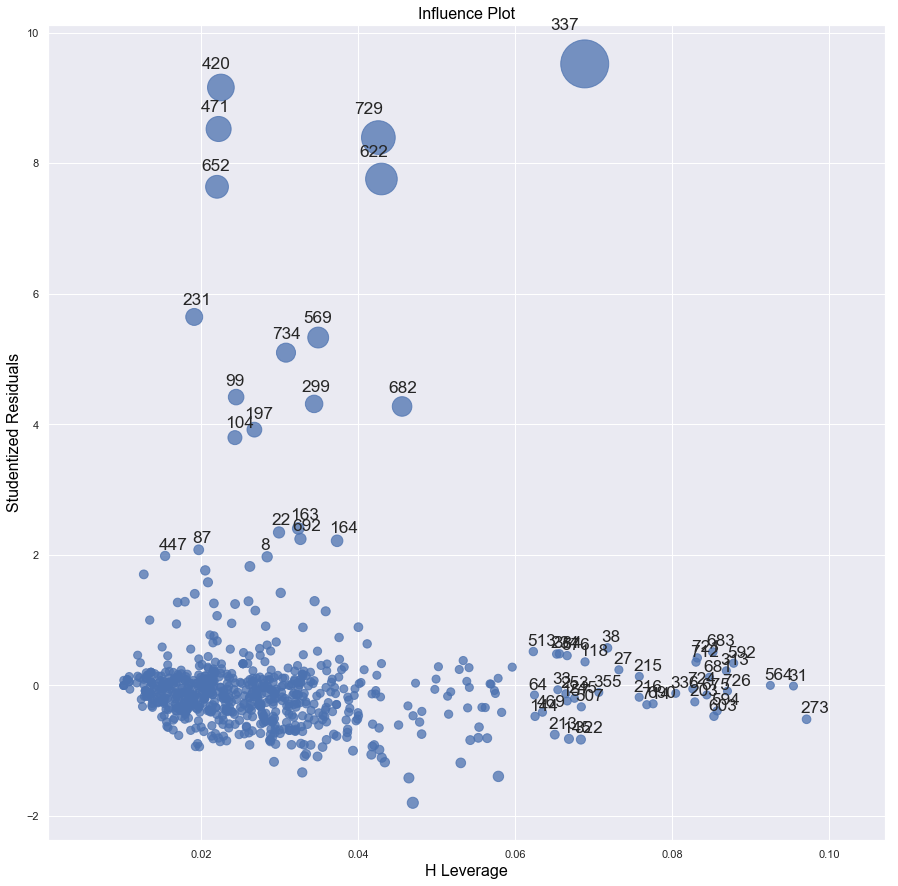

In [70]:
sns.set(rc={'figure.figsize':(15,15)})
sm.graphics.influence_plot(model, alpha = 0.05, criterion="cooks")

# Feature Selection

## Correlation

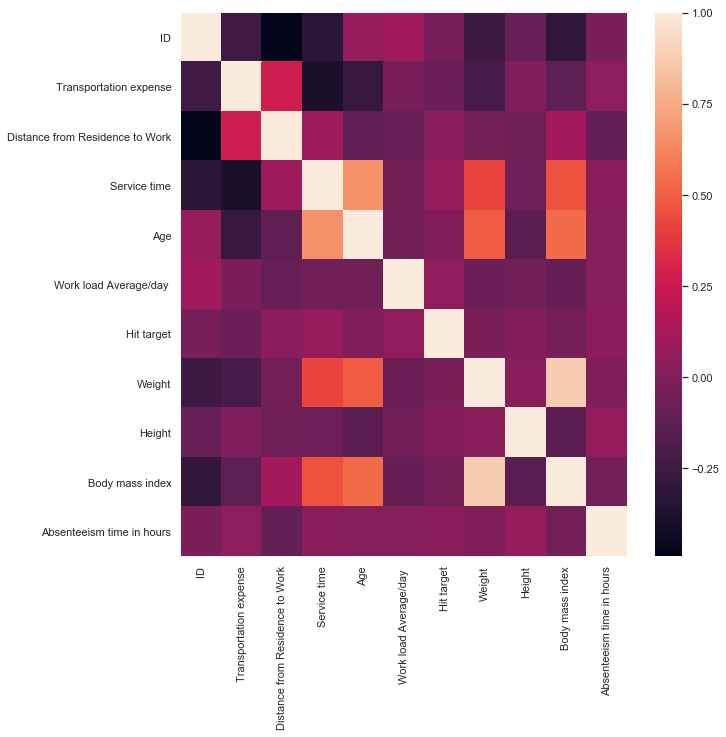

In [71]:
sns.set(rc={'figure.figsize':(10,10)})

sns.heatmap(Data.corr())

### Highly correlated variables
Weight ~ Body mass Index<br/>
Age ~ Service time

### Corrrelation Test with VIF

In [72]:
col = list(Data_dum.columns)
col.remove('Absenteeism time in hours')
print(col)

['ID', 'Transportation expense', 'Distance from Residence to Work', 'Service time', 'Age', 'Work load Average/day ', 'Hit target', 'Weight', 'Height', 'Body mass index', 'Reason for absence0.0', 'Reason for absence1.0', 'Reason for absence2.0', 'Reason for absence3.0', 'Reason for absence4.0', 'Reason for absence5.0', 'Reason for absence6.0', 'Reason for absence7.0', 'Reason for absence8.0', 'Reason for absence9.0', 'Reason for absence10.0', 'Reason for absence11.0', 'Reason for absence12.0', 'Reason for absence13.0', 'Reason for absence14.0', 'Reason for absence15.0', 'Reason for absence16.0', 'Reason for absence17.0', 'Reason for absence18.0', 'Reason for absence19.0', 'Reason for absence21.0', 'Reason for absence22.0', 'Reason for absence23.0', 'Reason for absence24.0', 'Reason for absence25.0', 'Reason for absence26.0', 'Reason for absence27.0', 'Reason for absence28.0', 'Month of absence1.0', 'Month of absence2.0', 'Month of absence3.0', 'Month of absence4.0', 'Month of absence5.0

In [73]:
Data_vif = Data_dum.copy()
Data_vif = Data_vif[col]
#Data_vif = normalize(Data_vif, get_column_bytype(Data_vif, 'float64'))
print(Data_vif.head(1))
y=Data_dum['Absenteeism time in hours']
transformer = ReduceVIF(thresh=5)

Data_vif = transformer.fit_transform(Data_vif, y)

print(Data_vif.shape)


     ID  Transportation expense  Distance from Residence to Work  \
0  11.0                   289.0                             36.0   

   Service time   Age  Work load Average/day   Hit target  Weight  Height  \
0          13.0  33.0                239554.0        97.0    90.0   172.0   

   Body mass index  ...  Social drinker0.0  Social drinker1.0  \
0             30.0  ...                  0                  1   

   Social smoker0.0  Social smoker1.0  Pet0.0  Pet1.0  Pet2.0  Pet4.0  Pet5.0  \
0                 1                 0       0       1       0       0       0   

   Pet8.0  
0       0  

[1 rows x 84 columns]
ReduceVIF fit
ReduceVIF transform


G:\Anaconda\lib\site-packages\statsmodels\stats\outliers_influence.py:181: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Dropping Reason for absence0.0 with vif=inf
Dropping Month of absence1.0 with vif=inf
Dropping Day of the week2.0 with vif=inf
Dropping Year2007.0 with vif=inf
Dropping Seasons1.0 with vif=inf
Dropping Disciplinary failure0.0 with vif=inf
Dropping Education1.0 with vif=inf
Dropping Son0.0 with vif=inf
Dropping Social drinker0.0 with vif=inf
Dropping Social smoker0.0 with vif=inf
Dropping Pet0.0 with vif=5350.108414147761
Dropping Height with vif=2596.8031788627945
Dropping Hit target with vif=733.6822090826114
Dropping Body mass index with vif=395.56030771573035
Dropping Age with vif=250.8476118667189
Dropping Work load Average/day  with vif=112.2316910779459
Dropping Weight with vif=98.20276317276758
Dropping Transportation expense with vif=55.94488817250754
Dropping Reason for absence23.0 with vif=28.833863137220348
Dropping Distance from Residence to Work with vif=25.75433368411144
Dropping Service time with vif=17.804207383223808
Dropping Seasons4.0 with vif=11.327218536995453
Drop

In [74]:
#Data_vif['Year'] = Data['Year']
Data_vif['Absenteeism time in hours'] = Data['Absenteeism time in hours']
Data_vif.head(1)

,ID,Reason for absence1.0,Reason for absence2.0,Reason for absence3.0,Reason for absence4.0,Reason for absence5.0,Reason for absence6.0,Reason for absence7.0,Reason for absence8.0,Reason for absence9.0,...,Son2.0,Son3.0,Son4.0,Social smoker1.0,Pet1.0,Pet2.0,Pet4.0,Pet5.0,Pet8.0,Absenteeism time in hours
0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0


## Feature Scaling

In [75]:
Data_vif = standardize(Data_vif, get_column_bytype(Data_vif, 'float64'))

## Trend analysis

In [76]:
Data_trend = Data.copy()

In [77]:
Data_vif['Month_Continuous'] = 0

Data_vif.iloc[0:113,22] = Data_vif.iloc[0:113,2]
Data_vif.iloc[113:358,22] = Data_vif.iloc[113:358,2].apply(lambda mon : mon +12)
Data_vif.iloc[358:570,22] = Data_vif.iloc[358:570,2].apply(lambda mon : mon +24)
Data_vif.iloc[570:737,22] = Data_vif.iloc[570:737,2].apply(lambda mon : mon +36)

Data_vif.head(5)

,ID,Reason for absence1.0,Reason for absence2.0,Reason for absence3.0,Reason for absence4.0,Reason for absence5.0,Reason for absence6.0,Reason for absence7.0,Reason for absence8.0,Reason for absence9.0,...,Son3.0,Son4.0,Social smoker1.0,Pet1.0,Pet2.0,Pet4.0,Pet5.0,Pet8.0,Absenteeism time in hours,Month_Continuous
0,-0.638388,-0.148867,-0.036835,-0.036835,-0.052129,-0.063888,-0.104685,-0.144040,-0.090536,-0.073822,...,-0.14404,-0.242545,-0.280991,2.100743,-0.384414,-0.212905,-0.090536,-0.097857,-0.216903,0
1,1.632765,-0.148867,-0.036835,-0.036835,-0.052129,-0.063888,-0.104685,-0.144040,-0.090536,-0.073822,...,-0.14404,-0.242545,-0.280991,-0.475376,-0.384414,-0.212905,-0.090536,-0.097857,-0.517386,0
2,-1.365157,-0.148867,-0.036835,-0.036835,-0.052129,-0.063888,-0.104685,-0.144040,-0.090536,-0.073822,...,-0.14404,-0.242545,-0.280991,-0.475376,-0.384414,-0.212905,-0.090536,-0.097857,-0.367144,0
3,-1.001773,-0.148867,-0.036835,-0.036835,-0.052129,-0.063888,-0.104685,6.933111,-0.090536,-0.073822,...,-0.14404,-0.242545,3.554010,-0.475376,-0.384414,-0.212905,-0.090536,-0.097857,-0.216903,0
4,-0.638388,-0.148867,-0.036835,-0.036835,-0.052129,-0.063888,-0.104685,-0.144040,-0.090536,-0.073822,...,-0.14404,-0.242545,-0.280991,2.100743,-0.384414,-0.212905,-0.090536,-0.097857,-0.367144,0


In [78]:
Data_trend['Month_Continuous'] = 0

Data_trend.iloc[0:113,22] = Data_trend.iloc[0:113,2]
Data_trend.iloc[113:358,22] = Data_trend.iloc[113:358,2].apply(lambda mon : mon +12)
Data_trend.iloc[358:570,22] = Data_trend.iloc[358:570,2].apply(lambda mon : mon +24)
Data_trend.iloc[570:737,22] = Data_trend.iloc[570:737,2].apply(lambda mon : mon +36)

Data_trend.head(5)

,ID,Reason for absence,Month of absence,Day of the week,Year,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,...,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours,Month_Continuous
0,11.0,26.0,7.0,3.0,2007.0,1.0,289.0,36.0,13.0,33.0,...,1.0,2.0,1.0,0.0,1.0,90.0,172.0,30.0,4.0,7
1,36.0,0.0,7.0,3.0,2007.0,1.0,118.0,13.0,18.0,50.0,...,1.0,1.0,1.0,0.0,0.0,98.0,170.0,31.0,0.0,7
2,3.0,23.0,7.0,4.0,2007.0,1.0,179.0,51.0,18.0,38.0,...,1.0,0.0,1.0,0.0,0.0,89.0,170.0,31.0,2.0,7
3,7.0,7.0,7.0,5.0,2007.0,1.0,279.0,5.0,14.0,39.0,...,1.0,2.0,1.0,1.0,0.0,68.0,168.0,24.0,4.0,7
4,11.0,23.0,7.0,5.0,2007.0,1.0,289.0,36.0,13.0,33.0,...,1.0,2.0,1.0,0.0,1.0,90.0,172.0,30.0,2.0,7


G:\Anaconda\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


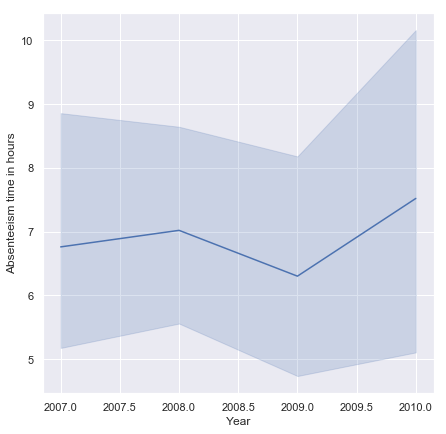

In [79]:
fig = plt.figure()
fig.set_size_inches(7,7)
warnings.filterwarnings(action='once')
sns.lineplot(x='Year', y = 'Absenteeism time in hours', data = Data_trend)

G:\Anaconda\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


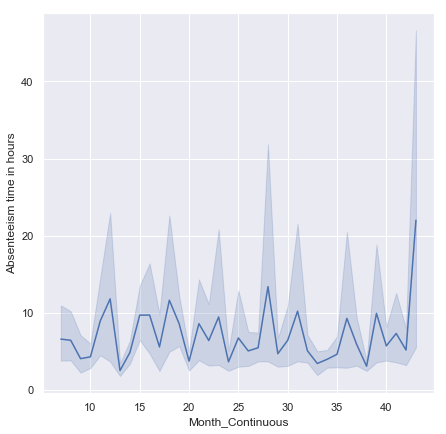

In [80]:
fig = plt.figure()
fig.set_size_inches(7,7)
warnings.filterwarnings(action='once')
sns.lineplot(x='Month_Continuous', y = 'Absenteeism time in hours', data = Data_trend)


 Seams there is no trend has been here with data. 
 Mean doesn't change over time. Hence its stationary
 Let's confirm it with  Dickey-Fuller test

In [81]:
dickey_test = adfuller(Data_vif['Absenteeism time in hours'], autolag='AIC')
dfoutput = pd.Series(dickey_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

for key,value in dickey_test[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Test Statistic                 -27.140193
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    736.000000
Critical Value (1%)             -3.439266
Critical Value (5%)             -2.865475
Critical Value (10%)            -2.568865
dtype: float64


#### Test statistics is smaller than Critical value. Hence it is stationary series
#### we can use regression for this kind of data

In [82]:
decomposition = seasonal_decompose(Data['Absenteeism time in hours'].values, freq = 24) 

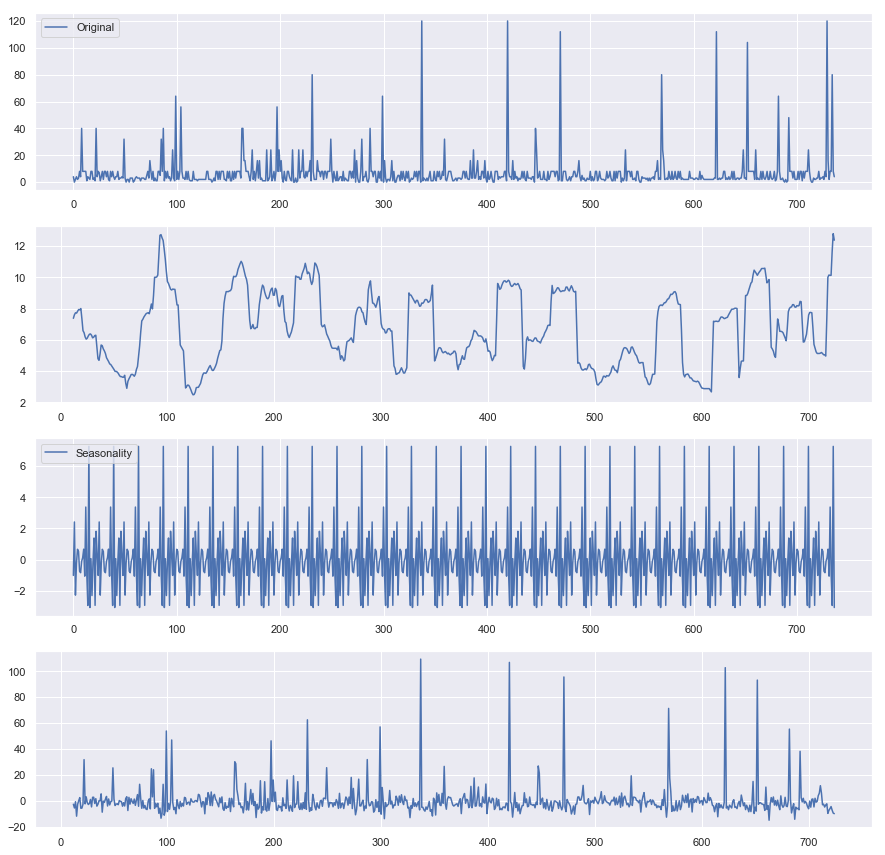

In [83]:
fig = plt.figure()
fig.set_size_inches(15,15)

plt.subplot(411) 
plt.plot(Data['Absenteeism time in hours'], label='Original') 
plt.legend(loc='best') 
plt.subplot(412) 
plt.plot(decomposition.trend, label='Trend') 
plt.subplot(413) 
plt.plot(decomposition.seasonal,label='Seasonality') 
plt.legend(loc='best') 
plt.subplot(414) 
plt.plot(decomposition.resid, label='Residuals') 
plt.show()

In [89]:
Data_trend_indexed = Data.groupby(['Year', 'Month of absence']).mean().dropna().reset_index()
#Data_trend_indexed = Data.groupby(['Year', 'Month of absence','Day of the week']).mean().reset_index().reset_index()
#Data_trend_indexed['Year_Month'] = list(Data.groupby(['Year', 'Month of absence', 'Day of the week']).groups.keys())
Data_trend_indexed

,Year,Month of absence,ID,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Weight,Height,Body mass index,Absenteeism time in hours
0,2007.0,7.0,11.473684,220.263158,38.157895,14.210526,36.842105,239554.000000,97.000000,81.000000,169.736842,27.263158,6.578947
1,2007.0,8.0,11.095238,258.619048,39.047619,11.476190,36.047619,205917.000000,92.000000,83.238095,170.285714,28.238095,6.428571
2,2007.0,9.0,19.454545,209.272727,32.045455,12.590909,36.363636,242511.136364,92.000000,79.818182,169.500000,26.590909,4.045455
3,2007.0,10.0,20.611111,221.166667,32.833333,11.833333,35.555556,254064.111111,93.000000,77.500000,170.000000,26.055556,4.277778
4,2007.0,11.0,17.944444,222.777778,29.611111,12.777778,35.166667,301667.666667,93.222222,76.000000,169.444444,25.611111,8.944444
5,2007.0,12.0,24.533333,222.866667,27.466667,10.666667,35.666667,261698.400000,96.866667,76.933333,169.800000,26.000000,11.800000
6,2008.0,1.0,28.666667,168.583333,19.583333,10.125000,33.166667,303050.000000,95.000000,78.416667,170.708333,26.083333,2.500000
7,2008.0,2.0,20.555556,225.777778,28.222222,10.166667,33.333333,302585.000000,99.000000,72.888889,169.166667,24.388889,4.833333
8,2008.0,3.0,20.000000,224.827586,30.344828,12.068966,34.689655,343253.000000,95.000000,72.000000,169.068966,24.896552,9.689655
9,2008.0,4.0,17.550000,238.550000,29.050000,13.150000,37.700000,326452.000000,96.000000,80.000000,170.100000,26.350000,9.700000


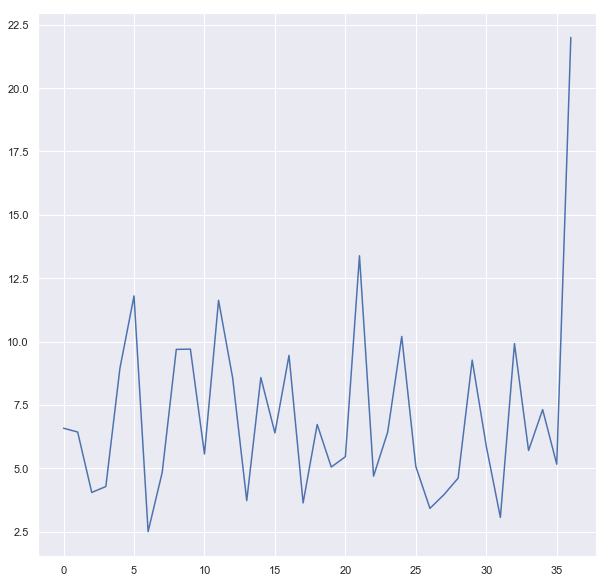

In [90]:
warnings.filterwarnings(action='once')
plt.plot(Data_trend_indexed['Absenteeism time in hours'])
plt.show()

In [91]:
lag_acf = acf(Data_trend_indexed['Absenteeism time in hours'], nlags=25) 
lag_pacf = pacf(Data_trend_indexed['Absenteeism time in hours'], nlags=25, method='ols')

In [92]:
lag_acf

array([ 1.        , -0.13894518, -0.12839535,  0.05165   ,  0.10150441,
       -0.11533364, -0.08841901,  0.09964697, -0.08587952, -0.10776471,
       -0.10517949, -0.03742688,  0.08740183,  0.07358359, -0.14615149,
        0.10874082,  0.04537129, -0.09377221, -0.02795615, -0.15500468,
        0.11006134, -0.0085978 , -0.02524134, -0.12745942,  0.1142618 ,
        0.1979732 ])

In [93]:
(lag_pacf)

array([  1.        ,  -0.25649743,  -0.28997161,  -0.03343792,
         0.18753342,  -0.15379442,  -0.15613308,   0.08412664,
        -0.19627932,  -0.2251778 ,  -0.40153476,  -0.27178468,
         0.05722773,   0.32768532,  -0.69795434,   0.81542975,
        -0.29677978,  -0.1534999 , -11.37262321,  -0.78439823,
         1.59234153,   1.08386302,  -0.0303773 ,   0.39126154,
         0.43038268,   0.80107539])

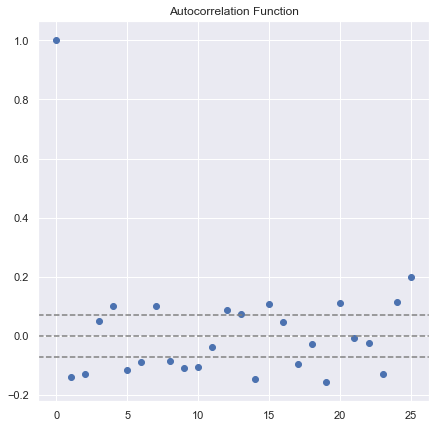

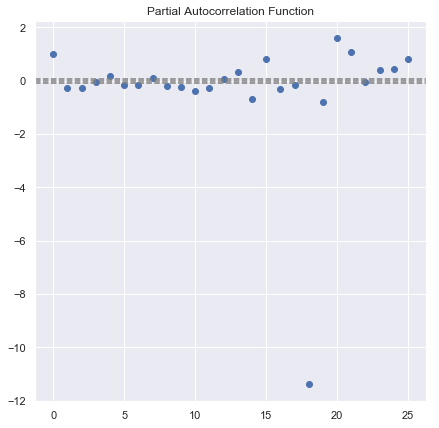

In [94]:
fig = plt.figure()
fig.set_size_inches(7,7)
plt.scatter(x=range(26),y=lag_acf) 
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(Data_trend)),linestyle='--',color='gray') 
plt.axhline(y=1.96/np.sqrt(len(Data_trend)),linestyle='--',color='gray')
plt.title('Autocorrelation Function') 
plt.show()
fig = plt.figure()
fig.set_size_inches(7,7)
plt.scatter(x=range(26),y=lag_pacf) 
plt.axhline(y=0,linestyle='--',color='gray') 
plt.axhline(y=-1.96/np.sqrt(len(Data_trend)),linestyle='--',color='gray') 
plt.axhline(y=1.96/np.sqrt(len(Data_trend)),linestyle='--',color='gray') 
plt.title('Partial Autocorrelation Function') 
plt.show()

## Prediction

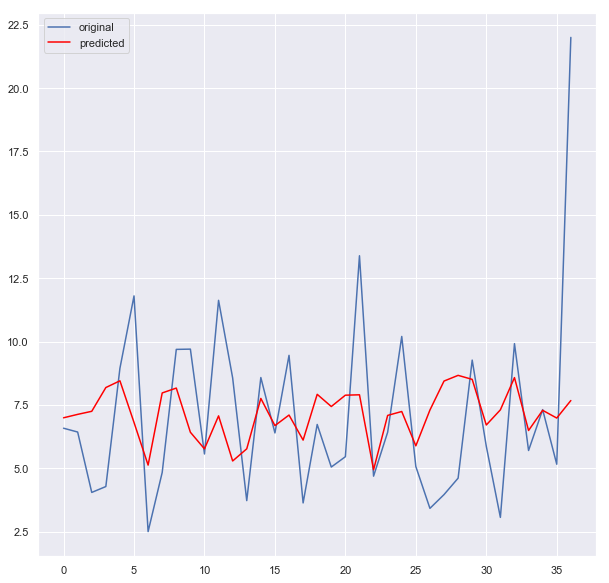

In [98]:
model = ARIMA(endog = Data_trend_indexed['Absenteeism time in hours'],order=(0,0,1))  
results_ARIMA = model.fit(disp=-1)  
plt.plot( Data_trend_indexed['Absenteeism time in hours'],  label='original') 
plt.plot(results_ARIMA.fittedvalues, color='red', label='predicted') 
plt.legend(loc='best') 
plt.show()

In [99]:
results_ARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  ARMA Model Results                                 
=====================================================================================
Dep. Variable:     Absenteeism time in hours   No. Observations:                   37
Model:                            ARMA(0, 1)   Log Likelihood                 -99.372
Method:                              css-mle   S.D. of innovations              3.542
Date:                       Tue, 23 Apr 2019   AIC                            204.745
Time:                               01:40:20   BIC                            209.578
Sample:                                    0   HQIC                           206.449
                                                                                     
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                               6.9904      0.377     18.536      0.000       6.251       7.730
ma.L1.Absenteeism time in hours    -0.3737      0.220     -1.702      0.098      -0.804       0.057
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            2.6758           +0.0000j            2.6758            0.0000
-----------------------------------------------------------------------------
"""